In [1]:
from IPython.display import YouTubeVideo, Markdown, SVG, Code
from functools import partial
YouTubeVideo_formato = partial(YouTubeVideo, modestbranding=1, disablekb=0,
                               width=640, height=360, autoplay=0, rel=0, showinfo=0)

display(Markdown(filename='../../preamble.md'))

### Instrucciones  y metodología asíncrona
Hola a todas y todos

- Este notebook forma parte del curso **INFO147: Computación científica con Python** de la carrera de Ingeniería Civil Informática de la Universidad Austral de Chile
- El profesor responsable es **Pablo Huijse**, por favor hacer sus consultas por slack o al correo phuijse at inf dot uach dot cl
- El material del curso se encuentra en https://github.com/magister-informatica-uach/INFO147 
- Se recomienda tener una copia local actualizada del repositorio


Para estudiar este material de forma asíncrona se recomienda seguir el flujo que se presenta a continuación

```bash 
for sección in notebook
do
    leer(sección) # Para incorporar los nuevos contenidos
    if ejercicios in sección
        resolver(ejercicios) # Para poner en práctica lo aprendido
    if video in sección
        ver(video) # Para profundizar y analizar la solución del ejercicio
done
```

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

# ¿Qué es la optimización de códigos/software?

Se refiere a modificar una rutina computacional para mejorar su eficiencia, es decir reducir sus

1. Tiempos de ejecución
1. Consumo de recursos 

El aspecto que se intenta modificar es aquel que limita nuestro programa, por ejemplo
- limitado en CPU (compute-bound)
- limitado en memoria (memory-bound)
- limitado en ancho de banda (bandwidth-bound)
- limitado en entrada/salida (I/O bound)

En el ámbito de la computación científica lo más común es enfrentar programas que están **límitados en CPU**, es decir 
- programas que utilizan la mayor parte de su tiempo haciendo cálculos
- programas que mejoran su rendimiento con la velocidad del CPU

**Una pequeña nota sobre los *trade-offs* en optimización**

En ciertos casos podemos disminuir el tiempo de ejecución de una rutina incrementando el uso de memoria 

Esto podría convertir un programa que es limitado en CPU a uno que es limitado en memoria

Siempre debemos tener en cuenta los posibles *trade-off* e identificarlos mediante *profiling*


# Unos consejos antes de optimizar

## ¿Cuándo optimizar?

`Si:` 

    tu rutina está incompleta o no entrega el resultado esperado
    
`Entonces:`

    No es momento de optimizar 

Dicho de otro modo, para casi cualquier rutina que escribamos deberíamos considerar la secuencia
1. que (la rutina) corra
1. que (la rutina) retorne el resultado correcto
1. (opcionalmente) que (la rutina) tenga un buen rendimiento

> La optimización está asociada al último punto y se lleva a cabo luego de cumplir los dos primeros

En la práctica hay que considerar que optimizar podría:
- Hacer el código más complicado y menos legible 
- Introducir bugs
- Tomar tiempo y bastante dedicación

Por lo tanto debemos evitar optimizar de forma prematura

> "La optimización prematura es la raíz de todos los males" - [Donald Knuth](http://wiki.c2.com/?PrematureOptimization)

## ¿Por qué optimizar?

En la secuencia mostrada anteriormente, podemos notar que el último punto no es esencial como lo son los dos primeros

Optimizar solo es necesario si nuestro código:
-  no entrega el resultado correcto en el tiempo requerido
-  requiere más memoria que la disponible en el hardware donde va a correr

## ¿Dónde optimizar?

Evita gastar tiempo optimizando rutinas que influyan poco en el rendimiento total del programa

La optimización debería concentrarse en las secciones más lentas y/o costosas

> Previo a optimizar debemos hacer un *profiling* de nuestro código para encontrar las secciones críticas


# Python y rendimiento | Parte 2

Como ya hemos mencionado **Python** es un lenguaje versátil pero poco eficiente en comparación a lenguajes de bajo nivel (C o Fortran)

Recordemos que **Python** es un lenguaje **interpretado**. Consideremos la operación

    z = x + y
    
Esta operación sencilla requiere de <font color="red">inferir el tipo</font> de $x$ e $y$ antes de sumarlos, luego debe <font color="red">escoger la función "suma" apropiada</font> y finalmente <font color="red">retornar el tipo correcto</font> de z

El costo de las operaciones en rojo se llama **overhead**, y es el **costo extra** de Python versus los lenguajes compilados

> Python nos da simpleza al costo de la eficiencia

Sin embargo, existen varias maneras de mejorar la eficiencia de un código escrito en Python. En esta clase veremos tres:

La primera y más fundamental es 

> **Conocer el lenguaje**: Usar la sintaxis y estructuras de Python adecuadamente 

Si tenemos un problema basado en arreglos podemos mejorar la eficiencia en varios órdenes de magnitud usando

> **Vectorización:** Cómputo basado en arreglos con `NumPy`

Finalmente, si las estructuras disponibles no son suficientes o si nuestros cálculos no son vectorizables se puede

> **Conectar con lenguajes de bajo nivel:** Uniendo Python y C con `Cython`

En la clase siguiente veremos como aprovechar las arquitecturas de CPU multi-nucleo con `Multiprocessing`

# Conocer el lenguaje para ganar eficiencia

**Python** tiene una curva de aprendizaje suave en comparación a lenguajes de más bajo nivel

Sabiendo muy poco de **Python** ya somos capaces de escribir toda clase de rutinas

Esto tiene un efecto secundario negativo en algunas personas y especialmente en aquellos que ya saben otros lenguajes 

> **Grave error:** Usar Python como si fuera C (o otro lenguaje)

Python ofrece una gran cantidad de [funciones](https://docs.python.org/3/library/functions.html) y [módulos en su librería estándar](https://docs.python.org/3/library/index.html) que son sumamente eficientes

Usar la sintáxis y las [estructuras de datos](https://docs.python.org/3/tutorial/datastructures.html) de Python adecuadamente es el primer paso para escribir código eficiente 

> Tenga siempre presente lo aprendido en su curso de algoritmos y busque en la documentación de Python las estructuras de datos más apropiadas para cada problema

Si necesita repasar se recomienda el siguiente material
- Bibliografía complementaria del curso: [Effective Python](https://effectivepython.com/)
- [Tratado de algoritmos y estructuras de datos en Python](https://runestone.academy/runestone/books/published/pythonds/index.html)
- [Consejos de velocidad en la Python wiki](https://wiki.python.org/moin/PythonSpeed)
- [Complejidad temporal de distintas estructuras de Python](https://wiki.python.org/moin/TimeComplexity)

A continuación algunos consejos generales

##  Evita usar `for` siempre que se pueda en favor de las funciones nativas

Muchas veces podemos evitar usar `for` con la estructura de datos o función adecuada

Para ejemplificar digamos que queremos sumar los valores absolutos de los elementos de una lista

In [ ]:
x = [x for x in range(100000)]

# Suma estilo C 
def suma_abs(data):
    resultado = 0
    for i in range(len(data)):
        if data[i] > 0:
            resultado += data[i]
        else:
            resultado -= data[i]
    return resultado

%timeit -r5 -n3 suma_abs(x)
display(suma_abs(x))

# Mejora: No es necesario usar un índice, podemos iterar directamente en los elementos
def suma_abs(data):
    resultado = 0
    for element in data:
        if element > 0:
            resultado += element
        else:
            resultado -= element
    return resultado

%timeit -r5 -n3 suma_abs(x)
display(suma_abs(x))

# Mejora: Operar como una comprensión de lista y luego usar la función sum de Python
%timeit -r5 -n3 sum([x if x> 0 else -x for x in x])
display(sum([x if x> 0 else -x for x in x]))

# Mejora: Usar las funciones sum, map y abs de Python
%timeit -r5 -n3 sum(list(map(abs, x)))
display(sum(list(map(abs, x))))

## No reinventes la rueda con las estructuras de datos

Verifica si la estructura que necesitas está implementada en Python antes de programarla tu

In [ ]:
x2 = list(np.random.randint(10, size=10000))

# Un contador de elementos
def miCounter(data):
    count = {}
    for element in data:
        if element not in count:
            count[element] = 1
        else:
            count[element] +=1
    return count

%timeit -r7 -n1 miCounter(x2)
display(miCounter(x2))

# Pero esto ya existe en collections
from collections import Counter
%timeit -r7 -n1 Counter(x2)
display(Counter(x2))

## Ojo con el overhead en funciones

Python tiene un overhead considerable cada vez que se llama una función

Se puede ganar desempeño haciendo *inlining* de funciones

In [ ]:
def cuadradomasuno(element):
    return element*element + 1

%timeit -r7 -n3 [cuadradomasuno(xi) for xi in x]
#Inlining: escribo la función textualmente en lugar de evaluarla
%timeit -r7 -n3 [xi*xi + 1 for xi in x] 
np.allclose([cuadradomasuno(xi) for xi in x], [xi*xi + 1 for xi in x] )

## Usa variables locales dentro de los loops

Si estamos obligados a usar `for` podemos ganar algo de rendimiento haciendo copias locales de atributos y funciones

Digamos que queremos crear una lista con todos los elementos de otra lista que cumplen la condición
$$
\sin(x[i]) > 0 
$$

In [ ]:
import math

# iterando sobre la lista
def sin_pos(data):
    resultado = []
    for element in data:
        if math.sin(element) > 0:
            resultado.append(element)
    return resultado

%timeit -r5 -n3 sin_pos(x)
resultado1 = sin_pos(x)

# variables locales
def sin_pos(data):
    resultado = []
    append = resultado.append
    sin = math.sin
    for element in data:
        if sin(element) > 0:
            append(element)
    return resultado

%timeit -r5 -n3 sin_pos(x)
resultado2 = sin_pos(x)
display(np.allclose(resultado1, resultado2))

# Vectorización: Cómputo basado en arreglos con NumPy


Consideremos el escenario en que tenemos un arreglo de datos de gran tamaño y queremos hacer una operación sobre cada elemento

**Ejemplo:** Dado $\{x\}_i$ queremos encontrar
$$
y_i = \frac{1}{1 + e^{-x_i}}, \quad i = 1,2,\ldots, N
$$

Cómputos de este tipo se catalogan como *

> SIMD*: Single Instruction Multiple Data, 

es decir que estamos haciendo una misma operación para todos los datos

Este problema se puede resolver usando un ciclo `for` 
    
    y = []
    for xi in x:
        y.append(1/(1+math.exp(-xi))
        
pero ya sabemos que esto es ineficiente en "Python puro"

> Las librerías de cómputo científico vistas en este curso nos ofrecen una mejor alternativa

En particular, **NumPy** nos provee de una estructura de arreglo multidimensional (ndarray) y funciones para operarla que están escritas en C y Fortran. Otras librerías como **Scipy** y **Pandas** se basan en **NumPy**

> Cuando utilizamos estas librerías estamos usando código compilado en lugar de interpretado 

Usando **NumPy** podemos reemplazar un ciclo `for` en problemas *SIMD* por operaciones que trabajan sobre todo el arreglo: **operaciones vectoriales**

**Ejemplo**

    y = 1/(1+np.exp(-x))
    
NumPy aplica la función exponencial a todo el arreglo x, luego aplica la aritmética (suma y división) a cada elemento del arreglo (broadcasting) y finalmente retorna un nuevo arreglo con el resultado

En general siempre que exista una operación de tipo *SIMD* podemos mejorar su rendimiento usando 

> **Vectorización:** Reemplazar un bucle/ciclo por operaciones vectoriales de **NumPy**

A continuación revisaremos mediante ejemplos como implementar este y otros conceptos para mejorar el rendimiento

## Reemplazar ciclo `for` por operaciones vectoriales

Las operaciones vectoriales son <font color="red"> funciones de NumPy</font> de tipo *element-wise* <font color="red">aplicadas sobre un ndarray</font>

Las funciones *element-wise* son aquellas que actuan sobre todos los elementos del arreglo de forma independiente
- En la clase de NumPy (unidad 1) revisamos algunos ejemplos: exponenciación, raíces, trigonometrícas, etc
- Las operaciones aritméticas entre ndarrays son por defecto *element-wise*

Luego si tenemos un problema SIMD escrito con un `for` sobre un conjunto de datos podemos 
1. Convertir los datos a ndarray
1. Escribir la operación con funciones de NumPy *element-wise*

y ganar considerablemente en eficiencia de forma directa

> Cuando las operaciones de NumPy se ejecutan sobre un ndarray se usa código compilado

Notemos la diferencia en tiempo de cómputo al hacer aritmética simple

In [ ]:
x_ndarray = np.random.randn(100000)
x_list = list(x_ndarray)

def operacion_simple(data):
    resultado = []
    append = resultado.append
    for elemento in data:
        append(elemento*elemento + elemento)
    return resultado

# Operación usando "for con mejoras"
%timeit -n3 -r7 operacion_simple(x_list)
# Operación usando numpy sobre un ndarray
%timeit -n3 -r7 x_ndarray*x_ndarray + x_ndarray
# Comparación entre los resultados
np.allclose(operacion_simple(x_list), x_ndarray*x_ndarray + x_ndarray)

Consideremos que

> Las funciones de NumPy son lentas cuando operan sobre tipos que no son ndarray

Para el ejemplo de $y_i = (1 + e^{-x_i})^{-1}, \quad i = 1,2,\ldots, N$

In [ ]:
from math import exp
# usando list comprehension (similar a un "for mejorado")
%timeit -n3 -r7 [1./(1.+exp(xi)) for xi in x_list]
# usando numpy sobre una lista
%timeit -n3 -r7 1./(1+np.exp(x_list))
# usando numpy sobre un ndarray
%timeit -n3 -r7 1./(1+np.exp(x_ndarray))
# Comparación entre los resultados
np.allclose(1./(1+np.exp(x_ndarray)), [1./(1.+exp(xi)) for xi in x_list])

Las operación sobre ndarray es casi un orden de magnitud más rápida

**¿Cómo se explica esto?**

Una lista puede tener distintos tipos y estar guardada en distintos sectores de memoria

En cambio, el ndarray
- Tiene un tipo definido 
- Está guardado en bloques de memoria contiguos

> El ndarray tiene un overhead de interpretador mucho menor 

NumPy está escrito en C, hacer un loop en memoría contigua en C es muy eficiente

> Se aprovechan las funciones eficientes de NumPy

Además se aprovecha mejor las capacidades del hardware 

> Recuerdo de arquitectura de computadores: Cache de CPU e instrucciones vectoriales de CPU (Intel AVX)


## Convertir operaciones lógicas sobre arreglos en máscaras

Las operaciones lógicas en NumPy también son *element-wise* (Operaciones booleanas, clase NumPy, unidad 1)

Si queremos recuperar los elementos de un arreglo que cumplan una cierta condición podemos
1. Convertir los datos a ndarray
1. Escribir la operación como una máscara booleana de índices

Para el ejemplo anterior de recuperamos los elementos tal que $\sin(x_i)>0$

In [ ]:
import math

def sin_pos(data):
    resultado = []
    append = resultado.append
    sin = math.sin
    for element in data:
        if sin(element) > 0:
            append(element)
    return resultado

%timeit -r5 -n3 sin_pos(x_list)

%timeit -r5 -n3 x_ndarray[np.sin(x_ndarray) > 0.]

display(np.allclose(sin_pos(x_list), x_ndarray[np.sin(x_ndarray) > 0]))

## Usa operaciónes *in-place* y vistas de arreglos para evitar copia extra de datos

Cuando en NumPy hacemos

    x = x*x
    
Se crea una copia interna de x*x, y luego x es direccionado a esa nueva copia

La zona de memoria con el valor original es luego eliminada por el *garbage-collector* de Python

> Siempre que no necesitemos el valor original podemos usar operaciones *in-place* y ganar rendimiento

Ya que evitamos la copia y eliminación adicional

In [ ]:
# Copia interna y cambio de referencia de x_ndarray 
%timeit -r10 -n10 x_ndarray = np.zeros(shape=(1000000)); y = x_ndarray*x_ndarray
# Sin copia interna
%timeit -r10 -n10 x_ndarray = np.zeros(shape=(1000000)); x_ndarray *= x_ndarray
# El resultado es idéntico
x_ndarray = np.zeros(shape=(1000000))
y = x_ndarray*x_ndarray
x_ndarray *= x_ndarray
np.allclose(x_ndarray, y)

Sea $x$ un arreglo, la operación

    x[2:10] 
    
es una "vista de x"

Las "vista de arreglo" no hacen copias en memoria ya que apuntan directamente al arreglo original

> Si modificamos una vista modificamos el original

## Aprovecha el *broadcasting* automático de NumPy

Se pueden hacer operaciones vectorizadas con NumPy entre arreglos con tamaños distintos

En ese caso se aplican las reglas de *broadcasting* que vimos en la unidad 1 (clase NumPy)

El *broadcasting* automático no hace copias en memoria

- Si le sumas una constante a un arreglo 1D, la constante se expande y se suma a cada elemento

In [ ]:
N = 1000000
x = np.zeros(shape=(N, ))
# broadcasting automático
%timeit -n10 -r10 x + 1.
# Agrandando y luego sumando
%timeit -n10 -r10 x + np.tile([1], len(x))
# mismo resultado
np.allclose(x + 1, x + np.tile([1], len(x)))

- Si le sumas un arreglo 1D a un arreglo 2D, el arreglo 1D se expande en la dimensión que le falta

In [ ]:
N, M = 10000, 1000
x = np.zeros(shape=(N, M)) # arreglo de NxM
y = np.zeros(shape=(N, )) # arreglo sin dimensión
y_ = y[:, np.newaxis] # arreglo de Nx1
# broadcasting automático
%timeit -n10 -r10 x + y_
display((x + y_).shape)
# Agrandando y luego sumando
%timeit -n10 -r10 x + np.tile(y_, (1, x.shape[-1]))
# mismo resultado
np.allclose(x + y_, x + np.tile(y_, (1, x.shape[-1])))

- Si sumas un arreglo 1D fila y un arreglo 1D columna se crea un arreglo 2D

In [ ]:
N, M = 10000, 1000
x = np.zeros(shape=(N, 1)) # arreglo columna de Nx1
y = np.zeros(shape=(1, M)) # arreglo fila de 1xM
# broadcasting automático
%timeit -n10 -r10 x + y
display((x+y).shape)
# Agrandando y luego sumando
%timeit -n10 -r10 np.tile(y, (x.shape[0], 1)) + np.tile(x, (1, y.shape[-1]))
np.allclose(x + y, np.tile(y, (x.shape[0], 1)) + np.tile(x, (1, y.shape[-1])))

Regla de oro

> Las dimensiones de dos arreglos son compatibles con *broadcast* automático si **son del mismo tamaño** o **una de ellas es igual a uno**

## Utiliza el ordenamiento en memoría más adecuado en cada caso

Como vimos en la unidad 1 (clase NumPy), los ndarray multidimensionales pueden guardarse en memoria como *row-major* (filas contiguas) o *column-major* (columnas contiguas)

Por defecto las matrices en NumPy son *row-major* pero podemos forzar la contigüidad usando el atributo `order` o trasponiendo (ojo que trasponer crea una copia)

Se puede verificar esto con el atributo `flag`

In [ ]:
data = np.arange(6).reshape(2, 3)
display(data)
# Verificamos los flags
display(data.flags)
# Así se ve row-major en memoria 
display(data.ravel())
# Verificamos los flags
dataT = data.T
display(dataT.flags)
# Así se ve column-major en memoria
display(dataT.ravel())

La mayoría de las funciones de NumPy funcionan más rápido en formato *row-major* (formato C)

Algunas funciones de scipy (heredadas de Fortran) funcionan más rápido en formato *col-major* (formato Fortran)

Es recomendable verificar el orden en memoria que espera la función que vas a utilizar

In [ ]:
data = np.random.randn(10000, 10000) # (row-major)
# Sumando una fila
%timeit -n100 -r10 np.sum(data[0, :])
# Sumando todas las filas
%timeit -n10 -r10 np.sum(data, axis=1)
# Sumando una columna
%timeit -n100 -r10 np.sum(data[:, 0])
# Sumando todas las columnas
%timeit -n10 -r10 np.sum(data, axis=0)
# Sumando todas las columnas de la matriz traspuesta (column major)
%timeit -n10 -r10 np.sum(data.T, axis=0)

# Ejemplo: Vectorizando el cálculo del "Set de Julia"

Consideremos el código en "Python puro" que vimos en la clase de *profiling*

<IPython.core.display.Javascript object>


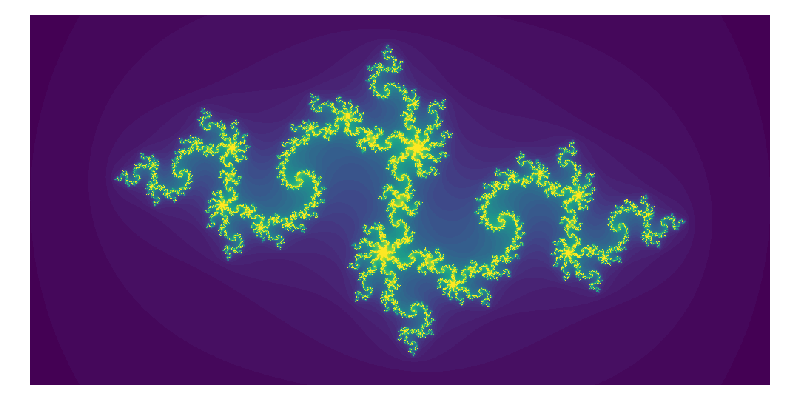

In [26]:
def evaluate(zi, zr, maxiters=50, cr=-0.835, ci=-0.2321):
    nit = 0
    zi2 = zi*zi
    zr2 = zr*zr
    while zi2 + zr2 <= 4. and nit < maxiters:
        zi = 2*zr*zi + ci
        zr = zr2 - zi2 + cr
        zr2 = zr*zr
        zi2 = zi*zi
        nit +=1
    return nit
    
def make_fractal(N, maxiters=50):
    image = []
    for i in range(N):
        row = []
        for j in range(2*N):
            zi = -1.0 + i*2/N
            zr = -2.0 + j*2/N
            row.append(evaluate(zi, zr, maxiters))
        image.append(row)
    return image

plt.figure(figsize=(8, 4), tight_layout=True)
plt.gca().axis('off')
plt.imshow(make_fractal(500));

El tiempo total para calcular el fractal con una resolución de 500x1000 es

In [27]:
%timeit -r3 -n1 make_fractal(500)

1.81 s ± 19.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Estudiando el código nos damos cuenta que la función `evaluate` se ejecuta de forma secuencial para cada uno de los 500x1000 píxeles

Si guardamos la imagen y los valores de $z$ como un `ndarray` podemos actualizar todos los pixeles "al mismo tiempo"

In [28]:
def make_fractal_vectorized(N, maxiters=50):
    image = np.zeros(shape=(N, 2*N), dtype=np.int64)
    zi = np.linspace(-1, 1, num=N, endpoint=False).reshape(-1, 1)
    zr = np.linspace(-2, 2, num=2*N, endpoint=False).reshape(1, -1)
    # Creamos arreglos de 2NxN para zi y zr 
    zi = np.repeat(zi, repeats=2*N, axis=1)
    zr = np.repeat(zr, repeats=N, axis=0)
    cr, ci = -0.835, -0.2321
    nit = 0
    while nit < maxiters:
        zr2 = zr*zr # operaciones vectoriales
        zi2 = zi*zi
        mask = zr2 + zi2 <= 4. #mascara booleana
        image[mask] += 1
        zi[mask] = 2*zr[mask]*zi[mask] + ci
        zr[mask] = zr2[mask] - zi2[mask] +  cr
        nit += 1
    return image

# Los resultados comparados:
np.allclose(make_fractal(500), make_fractal_vectorized(500))

True

El resultado es idéntico al código secuencial en "Python puro"

El tiempo total para calcular el fractal usando el código vectorizado es:

In [29]:
%timeit -r3 -n1 make_fractal_vectorized(500)

476 ms ± 8.55 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


El *speed-up* es el tiempo de la nueva rutina dividido el tiempo de referencia (rutina secuencial)

¿Cuánto es el *speed-up* en este caso?

**Propuesto**

- Usa operaciones *inplace* para aumentar el rendimiento
- Además:
    - En cada iteración del `while` calculamos el cuadrado de todos los $z$ 
    - Sin embargo lo más correcto sería calcular los cuadrados solo para los $z$ que cumplieron con la condición $|z| < 4$ la iteración anterior
    - Considere esta observación para optimizar aun más el código de `make_fractal_vectorized` ¿Cuánto *speed-up* obtienes?

# CPython 

La [implementación](https://wiki.python.org/moin/PythonImplementations) de Python más utilizada está escrita en C y se llama [CPython](https://github.com/python/cpython)

La implementación es aquello que interpreta y corre el código escrito en Python

Otras implementaciones de Python:
- [PyPy](http://www.pypy.org/en)
- [Jython](https://www.jython.org/) (escrito en Java)
- IronPython (escrito en C#)

CPython compila el código escrito en Python en un código de máquina (binario). Luego CPython interpreta el binario

Podemos estudiar dicho código usando el módulo [dis](https://docs.python.org/3.7/library/dis.html) de Python

In [ ]:
import dis
dis.dis(make_fractal)

Si sabemos C podemos usar la [API de Python/C](https://docs.python.org/3/c-api/index.html) para 
1. Escribir modulos de C que puedan llamarse desde Python
1. Hacer interfaces entre código C y Python

Sin embargo la API es complicada y existen alternativas menos tediosas para lograr estos objetivos
- [ctypes](https://docs.python.org/2/library/ctypes.html) 
- [CFFI](https://cffi.readthedocs.io/en/latest/)
- [SWIG](http://swig.org/)
- Cython

A continuación nos enfocaremos en esta última


# [Cython](https://cython.org/): C Extensions for Python

Recordemos:

**Python** es un lenguaje interpretado con tipos dinámicos. Esto hace que cada operación tenga un overhead.

    z = x + y
    # overhead: Inferir el tipo de x
    # overhead: Inferir el tipo de y
    # Hacer la operación suma
    # overhead: Darle el tipo adecuado a z
   
en cambio:

**Cython** es un lenguaje de programación que le agrega a Python algunas propiedades de C y C++, una de ellas son los **tipos estáticos**

    int x = 1
    int y = 2
    int z = x + y
    # No hay que inferir el tipo de x, y, z

- Esto hace que Cython sea menos flexible pero decenas de veces más rápido que  Python
- En términos de sintaxis Cython es casi tan simple como Python 
- A diferencia de Python, el lenguaje Cython debe compilarse
    - El compilador de Cython convierte el código fuente en código C 
    - Luego el código C se compila como un módulo de Python con la implementación **CPython**

En pocas palabras
> Una vez compilado el código escrito en Cython puede llamarse desde Python!

¿Por qué considerar Cython?
- Cython es casi tan simple como Python y casi tan rápido como C
- Con Cython se pueden llamar funciones y librerías de C
- Cython se integra de buena manera con NumPy

Por ende Cython es muy atractivo para proyectos que usen Python y tengan requisitos de alto rendimiento

Estudiemos la sintaxis de Cython mediante algunos ejemplos

## Ejemplo: Distancia euclidiana todos-con-todos

Sea un conjunto de $N=1000$ datos bidimensionales ($D=2$)

Queremos calcular la distancia euclidiana de cada dato con todos los demás, es decir una matriz donde el elemento $ij$ es 

$$
\text{dist}_{ij} = \sqrt {\sum_{k=1}^D (x_{ik} - x_{jk})^2}
$$

A continuación se muestran dos códigos que cumplen este proposito y obtienen un resultado equivalente

- El primero usa "Python puro" y calcula las distancias de forma secuencial
- El segundo usa operaciones vectoriales de NumPy y calcula las distancias "al mismo tiempo"

Estudie ambos códigos hasta comprenderlos

In [3]:
data = np.random.randn(1000, 2)

def distancia_pares(data):    
    N, D = data.shape
    dist = np.empty(shape=(N, N))
    for i in range(N):
        for j in range(i, N):
            dist[i, j] = 0
            for k in range(D):
                dist[i, j] += (data[i, k] - data[j, k])**2
            dist[i, j] = np.sqrt(dist[i, j])
            dist[j, i] = dist[i, j]
    return dist
            
def distancia_pares_numpy(data):
    return np.sqrt(np.sum((data.reshape(-1, 1, 2) - data.reshape(1, -1, 2))**2, axis=-1))

display(np.allclose(distancia_pares(data), 
                    distancia_pares_numpy(data)))
%timeit -r3 -n1 distancia_pares(data)
%timeit -r3 -n1 distancia_pares_numpy(data)

True

4.81 s ± 15.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
48.7 ms ± 778 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


## Cython en IPython

Ahora escribamos una versión en Cython de la función `distancia_pares`

Primero debemos instalar cython en nuestro ambiente de conda

    conda install cython

Luego en IPython podemos cargar la extensión `cython`

In [4]:
%load_ext cython

con esto tendremos disponible la magia de bloque `%%cython` 

- Esto hace que un bloque acepte lenguaje cython y que se compile al ejecutarlo
- Luego podremos llamar las funciones de ese bloque desde bloques regulares de Python
- Los errores de compilación aparecen como la salida del bloque
- Este bloque está "desconectado" del resto del notebook, por lo que debe tener sus propios `import`
- Opciones de magia 
    - `-a` (annotate) retorna un profile linea a linea indicando con amarillo las llamadas a CPython (mientras más llamadas más lento es nuestro código)
    - `-+` Usar C++ en lugar de C
    - `-c` Argumentos de compilación
    - `-l` librerías para linkear a nuestro código
    - `-L` directorio con librerías
    - `-I` directorio con cabeceras (include)   


In [5]:
%%cython -a

import numpy as np

def distancia_pares_cython_inocente(data):    
    N, D = data.shape
    dist = np.empty(shape=(N, N))
    for i in range(N):
        for j in range(i, N):
            dist[i, j] = 0.0
            for k in range(D):
                dist[i, j] += (data[i, k] - data[j, k])**2
            dist[i, j] = np.sqrt(dist[i, j])
            dist[j, i] = dist[i, j]
    return dist

In [6]:
display(np.allclose(distancia_pares(data), 
                    distancia_pares_cython_inocente(data)))
%timeit -r3 -n1 distancia_pares(data)
%timeit -r3 -n1 distancia_pares_numpy(data)
%timeit -r3 -n1 distancia_pares_cython_inocente(data)

True

4.47 s ± 43.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
46.3 ms ± 966 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
4.06 s ± 125 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Como no hemos hecho ningún cambio el resultado solo es levemente mejor que la versión en Python puro

El primer paso para ganar rendimiento es usar [**tipos estáticos** para las variables y las funciones](https://cython.readthedocs.io/en/latest/src/quickstart/cythonize.html)



### Definiendo tipos en Cython

En Cython se definen tipos estáticos con el keyword `cdef` seguido del tipo y luego el nombre 

Por ejemplo una variable de tipo `double` llamada `mi_variable`:

    cdef double mi_variable 
    
Para los arreglos se usan ["memory-views"](https://cython.readthedocs.io/en/latest/src/userguide/memoryviews.html#memoryviews)

Por ejemplo un *memory-view* para una arreglo de tres dimensiones:

    cdef double [:, :, :] mi_arreglo
    
Puede ganarase un poco más de rendimiento especificando si el arreglo es *row-major* (estilo C)

    cdef double [:, :, ::1] mi_arreglo
    
o *column-major* (estilo Fortran)

    cdef double [::1, :, :] mi_arreglo

In [9]:
%%cython -a 

import numpy as np

def distancia_pares_cython_estatico(double [:, ::1] data):
    # Definimos el tipo de N, D, dist y data
    cdef int N = data.shape[0]
    cdef int D = data.shape[1]
    dist = np.empty(shape=(N, N), dtype=np.double)
    cdef double [:, ::1] dist_view = dist
    # También definimos los índices, se puede usar int o Py_ssize_t 
    cdef int i, j, k
    for i in range(N):
        for j in range(i, N):
            dist_view[i, j] = 0.0
            for k in range(D):
                dist_view[i, j] += (data[i, k] - data[j, k])**2
            dist_view[i, j] = np.sqrt(dist_view[i, j])
            dist_view[j, i] = dist_view[i, j]
    return dist

In [10]:
display(np.allclose(distancia_pares(data), 
                    distancia_pares_cython_estatico(data)))
#%timeit -r3 -n1 distancia_pares(data)
%timeit -r3 -n1 distancia_pares_numpy(data) 
%timeit -r3 -n1 distancia_pares_cython_estatico(data)

True

50.8 ms ± 3.76 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
762 ms ± 7.59 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Con solo definir el tipo de data, dist, $N$, $D$ y los índices hemos obtenido un *speed-up* importante con respecto a "Python puro" aunque sigue siendo más lento que NumPy

Observemos el código anotado y revisemos la cantidad de llamadas a CPython de cada linea

La linea 17 es particularmente conflictiva 
- involucra una gran cantidad de instrucciones
- se llama NxN veces

esto se debe a que estamos usando la función de NumPy `np.sqrt` 

Podemos obtener un rendimiento mucho mejor si usamos la implementación de raíz cuadrada de C



### Llamando funciones de C desde Cython

Es posible llamar funciones de C desde Cython de forma sencilla

Consideremos como ejemplo la función `sqrt` de la [librería matemática estándar de C](http://pubs.opengroup.org/onlinepubs/9699919799/basedefs/math.h.html)

Necesitamos dos cosas
- Importar la función `sqrt` desde la cabecera `math.h`
    - Esto se hace con el keyword `cdef extern from`
- Compilar contra `libm`

In [11]:
%%cython -a -l m

import numpy as np

cdef extern from "math.h":
    double sqrt(double)

def distancia_pares_cython_sqrtC(double [:, ::1] data):
    # Definimos el tipo de N, D, dist y data
    cdef int N = data.shape[0]
    cdef int D = data.shape[1]
    dist = np.empty(shape=(N, N), dtype=np.double)
    cdef double [:, ::1] dist_view = dist
    # También definimos los índices, se puede usar int o Py_ssize_t 
    cdef Py_ssize_t i, j, k
    for i in range(N):
        for j in range(i, N):
            dist_view[i, j] = 0.0
            for k in range(D):
                dist_view[i, j] += (data[i, k] - data[j, k])**2
            dist_view[i, j] = sqrt(dist_view[i, j])
            dist_view[j, i] = dist_view[i, j]
    return dist

In [12]:
display(np.allclose(distancia_pares(data), 
                    distancia_pares_cython_sqrtC(data)))
#%timeit -r3 -n1 distancia_pares(data)
%timeit -r3 -n1 distancia_pares_numpy(data) 
%timeit -r3 -n1 distancia_pares_cython_estatico(data)
%timeit -r3 -n1 distancia_pares_cython_sqrtC(data)

True

51 ms ± 1.72 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
745 ms ± 2.47 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
7.42 ms ± 71.1 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


Con esta simple modificación hemos obtenido un tiempo de ejecución incluso menor que la implementación en NumPy


**Más importante aun:** usando `extern` podemos hacer interfaces [entre Python y casi cualquier código escrito en C](https://cython.readthedocs.io/en/latest/src/tutorial/clibraries.html)



### Deshabilitando comprobaciones para ir aun más rápido

Podemos hacer nuestro código más rápido (y más inseguro) deshabilitando las verificaciones que Python realiza por defecto

En Cython esto se hace usando decoradores que funcionan como directivas de compilación. Las opciones disponibles se encuentrán [aquí](https://cython.readthedocs.io/en/latest/src/userguide/source_files_and_compilation.html#compiler-directives)

En este caso deshabilitaremos dos verificaciones: *boundscheck* y *wraparound*

> El código no comprobará si escribimos fuera del arreglo y tampoco traducirá índices negativos

También aprovecharemos de hacer un cambio menor que nos será de utilidad más adelante:
- Definiremos el tipo de data y dist de forma más conveniente usando `ctypedef`
- Para esto incluiremos un modulo de Cython llamado numpy usando `cimport` que contiene definiciones tipo C   

In [37]:
%%cython -a -l m
import cython
cimport numpy as npc
import numpy as np

# Por conveniencia podemos definir el tipo de data y dist con 
ctypedef npc.float64_t TIPO_t
TIPO = np.float64

cdef extern from "math.h":
    TIPO_t sqrt(TIPO_t)

# Deshabilitamos las comprobaciones de Python:
@cython.boundscheck(False)
@cython.wraparound(False)
def distancia_pares_cython(TIPO_t [:, ::1] data):
    cdef int N = data.shape[0]
    cdef int M = data.shape[1]
    dist = np.empty(shape=(N, N), dtype=TIPO)
    cdef TIPO_t [:, ::1] dist_view = dist
    cdef Py_ssize_t i, j, k
    for i in range(N):
        for j in range(i, N):
            dist_view[i, j] = 0.0
            for k in range(M):
                dist_view[i, j] += (data[i, k] - data[j, k])**2
            dist_view[i, j] = sqrt(dist_view[i, j])
            dist_view[j, i] = dist_view[i, j]
    return dist


Error compiling Cython file:
------------------------------------------------------------
...
    for i in range(N):
        for j in range(i, N):
            dist_view[i, j] = 0.0
            for k in range(M):
                dist_view[i, j] += (data[i, k] - data[j, k])**2
            dist_view[i, j] = npc.sqrt(dist_view[i, j])
                                ^
------------------------------------------------------------

/home/phuijse/.cache/ipython/cython/_cython_magic_17e7cb574755152ad235810aba50b891.pyx:26:33: cimported module has no attribute 'sqrt'


In [22]:
display(np.allclose(distancia_pares(data), 
                    distancia_pares_cython(data)))
#%timeit -r3 -n1 distancia_pares(data)
%timeit -r3 -n1 distancia_pares_numpy(data) 
%timeit -r3 -n1 distancia_pares_cython_estatico(data)
%timeit -r3 -n1 distancia_pares_cython_sqrtC(data)
%timeit -r3 -n1 distancia_pares_cython(data)

True

48.9 ms ± 3.41 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
764 ms ± 8.27 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
7.46 ms ± 390 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
7.17 ms ± 139 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


Un leve speed-up "casi gratis"

###  Mayor flexibilidad con tipos de Cython fusionados 

En este momento es importante recordar lo que hemos perdido con Cython: **Flexibilidad**

Si usamos un argumento que no sea `double` nuestra función en Cython retornará un error

Es nuestra responsabilidad evitar que esto ocurra

In [23]:
display("La función funciona para tipo: ", data.dtype)
data_float32 = data.astype(np.float32)
display("Pero retorna un error si la ejecutamos con", data_float32.dtype)
distancia_pares_cython(data_float32)

'La función funciona para tipo: '

dtype('float64')

'Pero retorna un error si la ejecutamos con'

dtype('float32')

ValueError: Buffer dtype mismatch, expected 'TIPO_t' but got 'float'

Podemos aliviar este problema usando la definición de tipos fusionado de Cython

    ctypedef fused NOMBRE:

En esta caso modificaremos la función `distancia_pares_cython` para que acepte los tipos double e float

"Por debajo" Cython creará dos funciones en lugar de una

No hay que olvidar importar la definición de `sqrtf` de `math.h`

In [24]:
%%cython -a -l m
import cython
cimport numpy as npc
import numpy as np

# Tipo fusionado
ctypedef fused TIPO_t:
    npc.float32_t
    npc.float64_t # double
    
cdef extern from "math.h":
    npc.float32_t sqrtf(npc.float32_t) #Definición para float32
    npc.float64_t sqrt(npc.float64_t) # Definición para float64

@cython.boundscheck(False)
@cython.wraparound(False)
def distancia_pares_cython_multitipo(TIPO_t [:, ::1] data):
    cdef int N = data.shape[0]
    cdef int M = data.shape[1]
    # Comprobamos el tipo antes de crear el arreglo de numpy
    if TIPO_t is npc.float32_t:
        TIPO = np.float32
    else:
        TIPO = np.float64
    dist = np.empty(shape=(N, N), dtype=TIPO)
    cdef TIPO_t [:, ::1] dist_view = dist
    cdef Py_ssize_t i, j, k
    for i in range(N):
        for j in range(N):
            dist_view[i, j] = 0.0
            for k in range(M):
                dist_view[i, j] += (data[i, k] - data[j, k])**2
            if TIPO_t is npc.float32_t:
                dist_view[i, j] = sqrtf(dist_view[i, j])
            else:
                dist_view[i, j] = sqrt(dist_view[i, j])
    return dist

In [25]:
display(np.allclose(distancia_pares_numpy(data), 
                    distancia_pares_cython_multitipo(data)))
display(np.allclose(distancia_pares_numpy(data_float32), 
                    distancia_pares_cython_multitipo(data_float32)))
#%timeit -r3 -n1 distancia_pares(data_float32)
%timeit -r3 -n1 distancia_pares_numpy(data_float32)
%timeit -r3 -n1 distancia_pares_cython_multitipo(data_float32)

True

True

39 ms ± 1.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
6.94 ms ± 553 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


El resultado usando `float` es equivalente al de NumPy

La velocidad es similar a la de `distancia_pares_cython`. La pérdida de rendimiento no es notoria

## Ejemplo: "Cythonizando" el fractal de Julia

Partiendo del código de Python puro del fractal de Julia, escribimos una versión en Cython

Recordemos:

- Usamos `cdef` para definir las variables con tipo estático
    - También podemos usar `cdef` para definir funciones con tipo
    - Las funciones con tipo solo pueden ser llamadas por otras funciones de Cython
- Usamos `ctypedef` para definir tipos 
- Usamos `cimport` para importar otros módulos de Cython
- Usamos memory-views con el tipo adecuado para conectar con NumPy en la salida
- Deshabilitamos las comprobaciones de Python para ganar más velocidad

In [30]:
%%cython -a
import cython
cimport numpy as npc
import numpy as np

ctypedef npc.float64_t TIPOF_t
ctypedef npc.int64_t TIPOI_t

# Las funciones con cdef solo pueden ser llamadas desde Cython
cdef TIPOI_t evaluate_z(TIPOF_t zi, TIPOF_t zr, int maxiters=50, TIPOF_t cr=-0.835, TIPOF_t ci=-0.2321):
    cdef:
        TIPOI_t nit = 0
        TIPOF_t zi2 = zi**2
        TIPOF_t zr2 = zr**2
        
    while zi2 + zr2 <= 4. and nit < maxiters:
        zi = 2.*zr*zi + ci
        zr = zr2 - zi2 + cr
        zr2 = zr**2
        zi2 = zi**2 
        nit +=1
    return nit

# Las funciones con def pueden ser llamadas desde Python
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def make_fractal_cython(int N, int maxiters=50):
    image = np.empty(shape=(N, 2*N), dtype=np.int64)
    cdef TIPOI_t [:, ::1] image_view = image
    cdef:
        Py_ssize_t i, j
    # Los ndarray no se copian, los podemos modificar inplace desde Cython
    for i in range(N):
        for j in range(2*N):
            image_view[i, j] = evaluate_z(-1.+i*2./N, -2.+j*2./N, maxiters)
    return image

In [31]:
N = 500

display(np.allclose(make_fractal(N), make_fractal_cython(N) ))

%timeit -r3 -n1 make_fractal(N)
%timeit -r3 -n1 make_fractal_vectorized(N)
%timeit -r3 -n1 make_fractal_cython(N)

True

1.9 s ± 2.52 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
470 ms ± 1.08 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
24.1 ms ± 746 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


El resultado es idéntico al código secuencial en "Python puro" y el tiempo es considerablemente menor

Ahora podemos dibujar el fractal en mayor resolución en un tiempo razonable :)

<IPython.core.display.Javascript object>


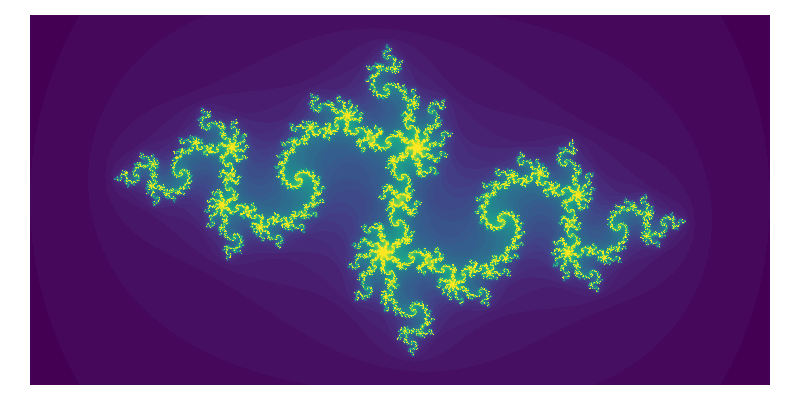

In [32]:
N = 4000

plt.figure(figsize=(8, 4), tight_layout=True)
plt.gca().axis('off')
plt.imshow(make_fractal_cython(N));

**Propuesto: Dibuje curvas de *speed-up* para**
- Cython vs "Python puro" 
- Cython vs Numpy 

considerando $N=10, 50, 100, 500, 1000, 5000$

## Usando Cython fuera de Jupyter

El código cython se guarda tipicamente con extensión `pyx`

Se genera un código C usando `cython` usando la opción `-3` para indicar que se usará Python 3

In [33]:
!cython -3 fractal_cython.pyx

Luego usamos nuestro compilador de C preferido apuntando adecuadamente a las cabeceras y librerías de Python 3 (y en este caso de NumPy también)

Debemos generar una libreria compartida (shared)

In [35]:
!gcc -I/usr/include/python3.8m/ -I/usr/lib/python3.8/site-packages/numpy/core/include/ -L/usr/lib -lm -lpython3 -fPIC -shared fractal_cython.c -o fractal_cython.so

fractal_cython.c:4:10: fatal error: Python.h: No such file or directory
    4 | #include "Python.h"
      |          ^~~~~~~~~~
compilation terminated.


Luego podemos importar la librería como un módulo de Python cualquiera

In [ ]:
from fractal_cython import make_fractal_cython as make_fractal_imported
image_cython_imported = np.empty(shape=(N, 2*N), dtype=np.int64)
make_fractal_imported(N, image_cython_imported)
np.allclose(image_cython, image_cython_imported)

Limpiamos nuestros compilados si ya no son necesarios:

In [ ]:
!rm fractal_cython.c fractal_cython.so

## Tópicos adicionales

Lecturas sobre temas específicos de Cython:
- [Incluyendo código Cython en un módulo de Python](https://cython.readthedocs.io/en/latest/src/quickstart/build.html#building-a-cython-module-using-distutils)
- [Haciendo profiling de código Cython](https://cython.readthedocs.io/en/latest/src/tutorial/profiling_tutorial.html)
- [Malloc/Free en Cython](https://cython.readthedocs.io/en/latest/src/tutorial/memory_allocation.html)
- Libro [Cython: A Guide for Python Programmers](https://pythonbooks.org/cython-a-guide-for-python-programmers/)

# Compilación Just-in-time (JIT) con [Numba](http://numba.pydata.org/)

Podemos acelerar cálculos científicos de forma simple y semi-automática usando el compilador **Numba**. Este compilador no requiere cambiar el interprete de Python y tampoco es necesario aprender otro lenguaje

A través de decoradores podemos pedirle a Numba que compile una función "al vuelo" (just-in-time). Internamente Numba traduce las funciones de Python a lenguaje de máquina usando el compilador [LLVM](https://llvm.org/)

Para "ciertas funciones" el resultado será una versión compilada notoriamente más rápida en su ejecución que la original. Numba está diseñado para hacer más eficiente rutinas *compute-bound* que hagan **cálculos numéricos**. Tiene soporte para compilar funciones de Numpy y para paralelizar automaticamente ciclos `for`

Instala Numba en tu ambiente de conda con

    conda install numba

A continuación veremos los decoradores fundamentales de *Numba* y algunos ejemplos

Volvamos al código vectorizado para calcular la distancia euclidiana "todos con todos"

In [ ]:
import numpy as np

data = np.random.randn(1000, 2)

def distancia_pares_numpy(data):
    return np.sqrt(np.sum((data.reshape(-1, 1, 2) - data.reshape(1, -1, 2))**2, axis=-1))

%timeit -r3 -n1 distancia_pares_numpy(data)

Para usar Numba

- Importamos el decorador `jit` y lo aplicamos a la función anterior
- Usaremos el modo `nopython` o "modo rápido", esto indica al compilador que la función no usará el interprete de Python
- La primera llamada a la función es lenta, pues acciona el compilador
- La siguientes llamadas son más rápidas que la función de NumPy

In [ ]:
from numba import jit

@jit(nopython=True)
def distancia_pares_numba(data):
    return np.sqrt(np.sum((data.reshape(-1, 1, 2) - data.reshape(1, -1, 2))**2, axis=-1))

distancia_pares_numba(data) # Aquí se ejecuta la compilación

%timeit -r3 -n1 distancia_pares_numba(data)

np.allclose(distancia_pares_numpy(data), 
            distancia_pares_numba(data))

- Existe un alias para `jit(nopython=True)` llamado `njit`
- Otros argumentos interesantes para decorar son: `parallel=True` y `fastmath=True` 

**Una nota sobre NumPy**

No todas las [funcionalidades y funciones de NumPy están soportadas](https://numba.pydata.org/numba-doc/latest/reference/numpysupported.html)

Por ejemplo en la función `make_fractal_vectorized` al intentar numbificar existen varios errores

- `linspace` sólo soporta la versión con tres argumentos
- `repeat` no acepta el argumento `axis`
- *fancy-indexing* en arreglos 2D no está soportado por lo que `image[mask] +=1` no funciona

En este caso podriamos intentar "numbificar" la versión no vectorizada

In [ ]:
from numba import njit

@njit
def evaluate_numba(zi, zr, maxiters=50, cr=-0.835, ci=-0.2321):
    nit = 0
    zi2 = zi*zi
    zr2 = zr*zr
    while zi2 + zr2 <= 4. and nit < maxiters:
        zi = 2*zr*zi + ci
        zr = zr2 - zi2 + cr
        zr2 = zr*zr
        zi2 = zi*zi
        nit +=1
    return nit

@njit
def make_fractal_numba(N, maxiters=50):
    image = []
    for i in range(N):
        row = []
        for j in range(2*N):
            zi = -1.0 + i*2/N
            zr = -2.0 + j*2/N
            row.append(evaluate_numba(zi, zr, maxiters))
        image.append(row)
    return image


N = 2000
make_fractal_numba(N)
#%timeit -r3 -n1 make_fractal(N)
%timeit -r3 -n1 make_fractal_vectorized(N)
%timeit -r3 -n1 make_fractal_numba(N)
%timeit -r3 -n1 make_fractal_cython(N)